<a href="https://colab.research.google.com/github/mz-zarei/TimeSeriesAnalysis/blob/main/PedestrianFlowForecasting/PedCrossVolumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline

# 1. Read Data

In [5]:
# Read the data
path_to_data = 'data/Burke_Gilman_Trail_north_of_NE_70th_St_Bicycle_and_Pedestrian_Counter.csv'
df_all = pd.read_csv(path_to_data, delimiter=';')
## Combine date/time columns and change the type to datetime 
df_all['Date'] = pd.to_datetime(df_all['Date'] + ' ' + df_all['time'], format='%Y-%m-%d %H:%M:%S')
## Set index as date column and sort
df_all.set_index('Date', inplace=True)
df_all.sort_index(inplace=True)
## Drop unused columns
df_all.drop(columns=['latitude', 'longitude', 'time', 'vol_vehicle'], inplace=True)

# Show unique intersections names
print(df_all.name.unique())
# Show first 10 rows
display(df_all.head())

KeyError: 'Date'

In [14]:
# Choose one/more intersection
df = df_all[df_all['name'] == 'Thompson Road and Nipissing Road']
# drop data after 2019-01-01
df = df[df.index > "2019-01-01"]

In [15]:
# Check if there is any Null target values
print('Number of null values (ped_N): {0}'.format(df.ped_N.isnull().sum()))
print('Number of null values (ped_S): {0}'.format(df.ped_S.isnull().sum()))
print('Number of null values (ped_E): {0}'.format(df.ped_E.isnull().sum()))
print('Number of null values (ped_W): {0}'.format(df.ped_W.isnull().sum()))

Number of null values (ped_N): 0
Number of null values (ped_S): 0
Number of null values (ped_E): 0
Number of null values (ped_W): 0


In [16]:
# Resample data to get daily or weekly or monthly counts
aggregation = 'D'
df_r = df.resample(aggregation).sum()

# Check for duplicate index values
print('Duplicate dates in our data (before): ', df_r.index.duplicated().sum())

# Summary statistics
df_r.describe()

Duplicate dates in our data (before):  0


,ped_N,ped_S,ped_E,ped_W
count,472.0,472.0,472.0,472.0
mean,0.0,13.5,0.0,173.7
std,0.0,13.5,0.0,118.9
min,0.0,0.0,0.0,0.0
25%,0.0,4.8,0.0,92.8
50%,0.0,11.0,0.0,153.5
75%,0.0,19.0,0.0,252.8
max,0.0,172.0,0.0,478.0


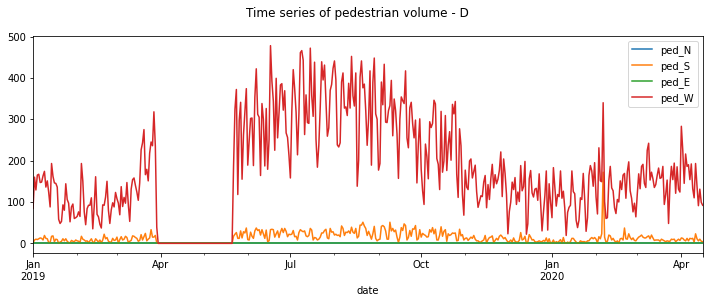

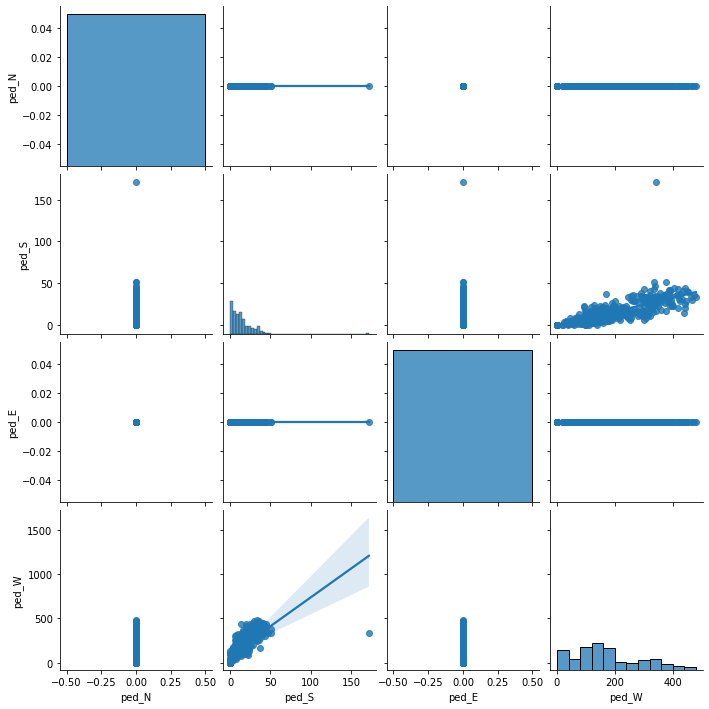

In [17]:
# Plotting the time series of Ped counts for each crossing
fig, axs = plt.subplots(1, figsize=(12, 4))
fig.suptitle('Time series of pedestrian volume - ' + aggregation)

df_r.ped_N.plot(ax=axs)
df_r.ped_S.plot(ax=axs)
df_r.ped_E.plot(ax=axs)
df_r.ped_W.plot(ax=axs)
axs.legend()
plt.show()

# Distributions and scatter pair plots
sns.pairplot(df_r, kind='reg')

In [ ]:
# Statistical tests for distributions
from scipy import stats

## T-test for mean
print('t-test ped_N/ped_S: ', stats.ttest_ind(df_r.ped_N.values, df_r.ped_S.values)[1])
print('t-test ped_W/ped_E: ', stats.ttest_ind(df_r.ped_E.values, df_r.ped_W.values)[1])

## Leven Test for variance
print('Leven-test ped_N/ped_S: ', stats.levene(df_r.ped_N.values, df_r.ped_S.values)[1])
print('Leven-test ped_W/ped_E: ', stats.levene(df_r.ped_E.values, df_r.ped_W.values)[1])

## KS Test for distrbution
print('KS-test ped_N/ped_S: ', stats.ks_2samp(df_r.ped_N.values, df_r.ped_S.values)[1])
print('KS-test ped_W/ped_E: ', stats.ks_2samp(df_r.ped_E.values, df_r.ped_W.values)[1])

t-test ped_N/ped_S:  1.5650208559244433e-48
t-test ped_W/ped_E:  6.102068696101359e-45
Leven-test ped_N/ped_S:  0.2281657541008601
Leven-test ped_W/ped_E:  1.6331578923123236e-17
KS-test ped_N/ped_S:  6.877275611453192e-60
KS-test ped_W/ped_E:  6.416775960993153e-29


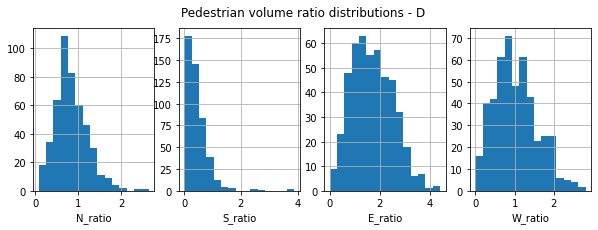

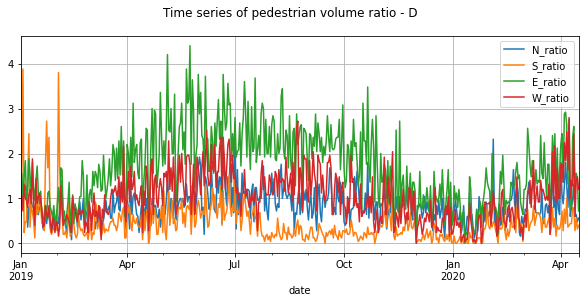

In [ ]:
# Calculate the ratio of crossing counts
df_r['N_ratio'] = df_r['ped_N'] / (0.25*(df_r['ped_S'].mean() + df_r['ped_N'].mean() + df_r['ped_E'].mean() + df_r['ped_W'].mean()))
df_r['S_ratio'] = df_r['ped_S'] / (0.25*(df_r['ped_S'].mean() + df_r['ped_N'].mean() + df_r['ped_E'].mean() + df_r['ped_W'].mean()))
df_r['W_ratio'] = df_r['ped_W'] / (0.25*(df_r['ped_S'].mean() + df_r['ped_N'].mean() + df_r['ped_E'].mean() + df_r['ped_W'].mean()))
df_r['E_ratio'] = df_r['ped_E'] / (0.25*(df_r['ped_S'].mean() + df_r['ped_N'].mean() + df_r['ped_E'].mean() + df_r['ped_W'].mean()))

# Plot the distribution of ratios
fig, axs = plt.subplots(1,4, figsize=(10, 3))
fig.suptitle('Pedestrian volume ratio distributions - ' + aggregation)

for i, data in enumerate(['N_ratio', 'S_ratio', 'E_ratio', 'W_ratio']):
    df_r[data].hist(ax=axs[i], bins=15)
    axs[i].set_xlabel(data)


# Plotting the time series of Ped counts ratios
fig, axs = plt.subplots(1, figsize=(10, 4))
fig.suptitle('Time series of pedestrian volume ratio - ' + aggregation)
df_r.N_ratio.plot(ax=axs)
df_r.S_ratio.plot(ax=axs)
df_r.E_ratio.plot(ax=axs)
df_r.W_ratio.plot(ax=axs)
axs.grid()
axs.legend()